In [98]:
import pandas as pd

In [99]:
bitcoin = pd.read_csv('datasets/coin_Bitcoin.csv')
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
bitcoin.set_index('Date', inplace=True)
bitcoin.index.freq = 'D'
bitcoin.head()

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


<Axes: xlabel='Date'>

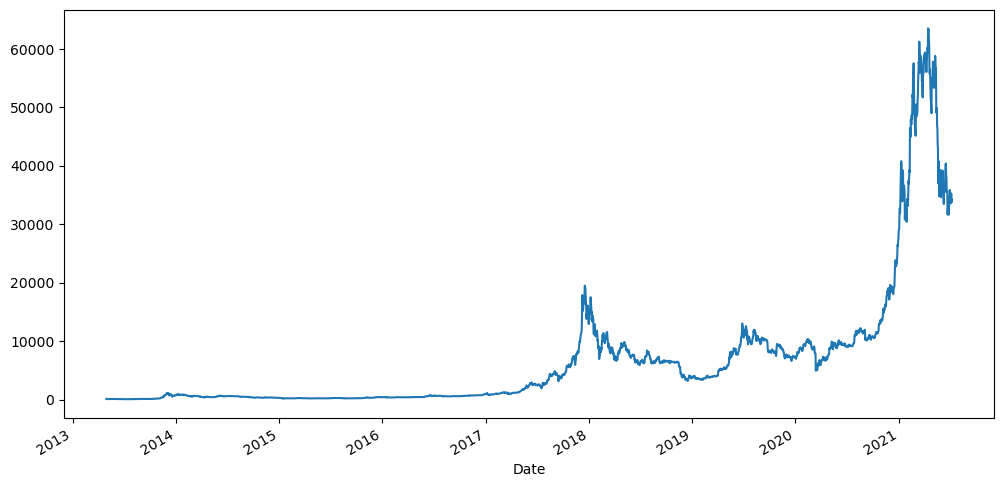

In [100]:
bitcoin['Close'].plot(figsize=(12, 6))

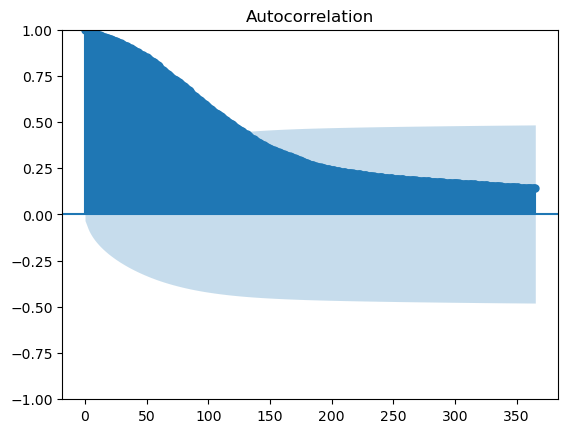

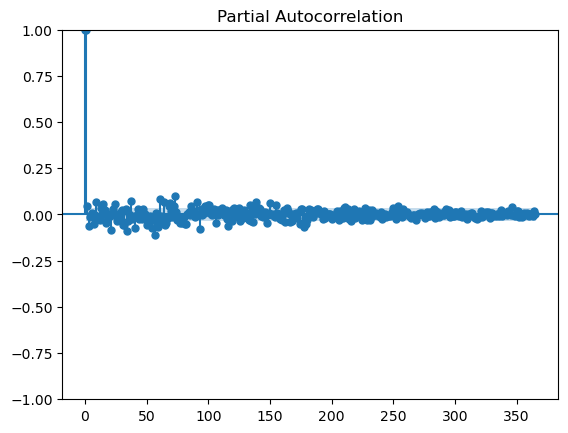

In [101]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(bitcoin['Close'], lags=365)
pacf = plot_pacf(bitcoin['Close'], lags=365)

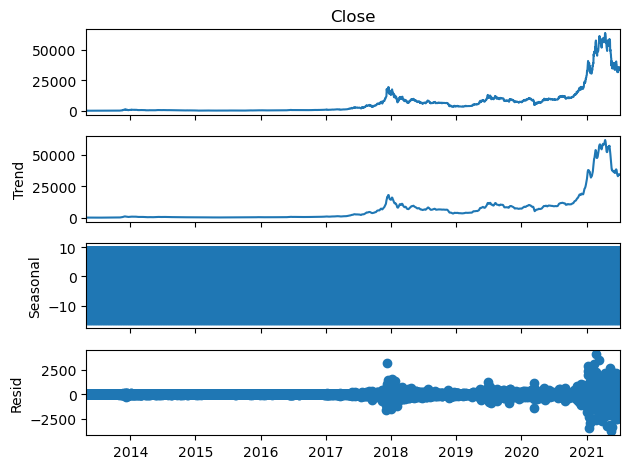

In [102]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(bitcoin['Close'], model='add')
result.plot();

Too frequent data intervals to notice any seasonality, let's try the monthly price. 

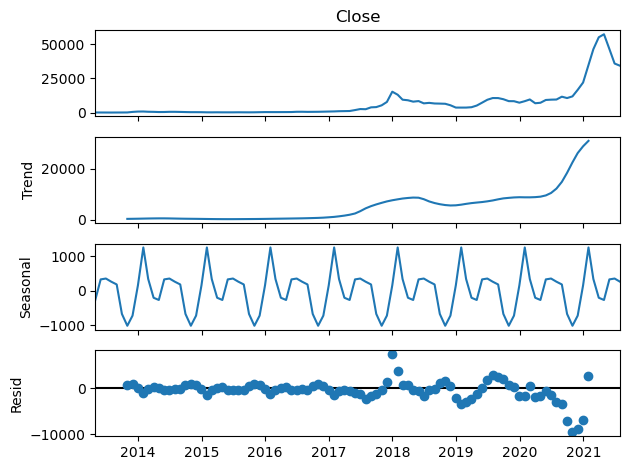

In [103]:
bitcoin_monthly = bitcoin['Close'].resample('M').mean()
seasonal_decompose(bitcoin_monthly, model='add').plot();

Monthly data exhibits clear yearly seasonality. 

In [104]:
from pmdarima import auto_arima

model = auto_arima(bitcoin_monthly, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1802.194, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1856.782, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1811.767, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1803.904, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1856.269, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1799.448, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1800.193, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=1800.035, Time=0.22 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1801.350, Time=0.12 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=1804.475, Time=0.23 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=1798.509, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1797.617, Time=0.17 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1799.734, Time=0.09 sec
 ARIMA(2,1,1)(1,0,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  100
Model:             SARIMAX(3, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -886.198
Date:                              Sat, 25 May 2024   AIC                           1792.397
Time:                                      21:54:22   BIC                           1818.348
Sample:                                  04-30-2013   HQIC                          1802.896
                                       - 07-31-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    205.8023    182.187      1.130      0.259    -151.277     562.881
ar.L1          0.7456      0.262      2.846      0.004       0.232       1.259
ar.L2         -0.2008      0.301     -0.667      0.505      -0.791       0.389
ar.L3         -0.4768      0.223     -2.139      0.032      -0.914      -0.040
ma.L1          0.0842      0.273      0.308      0.758      -0.451       0.619
ma.L2         -0.0720      0.208     -0.346      0.730      -0.480       0.336
ma.L3          0.5071      0.226      2.242      0.025       0.064       0.950
ar.S.L12       0.4784      0.296      1.615      0.106      -0.102       1.059
ma.S.L12      -0.8315      0.266     -3.128      0.002      -1.352      -0.311
sigma2      3.181e+06   4.54e+05      7.006      0.000    2.29e+06    4.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               265.07
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              56.98   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.52e+14. Standard errors may be unstable.
"""

In [105]:
arima_forecast_length = 6

In [106]:
train_arima = bitcoin_monthly.iloc[:-arima_forecast_length]
test_arima = bitcoin_monthly.iloc[-arima_forecast_length:]

In [107]:
model.fit(train_arima)
fitted_values = model.predict_in_sample()
forecast = model.predict(n_periods=arima_forecast_length)

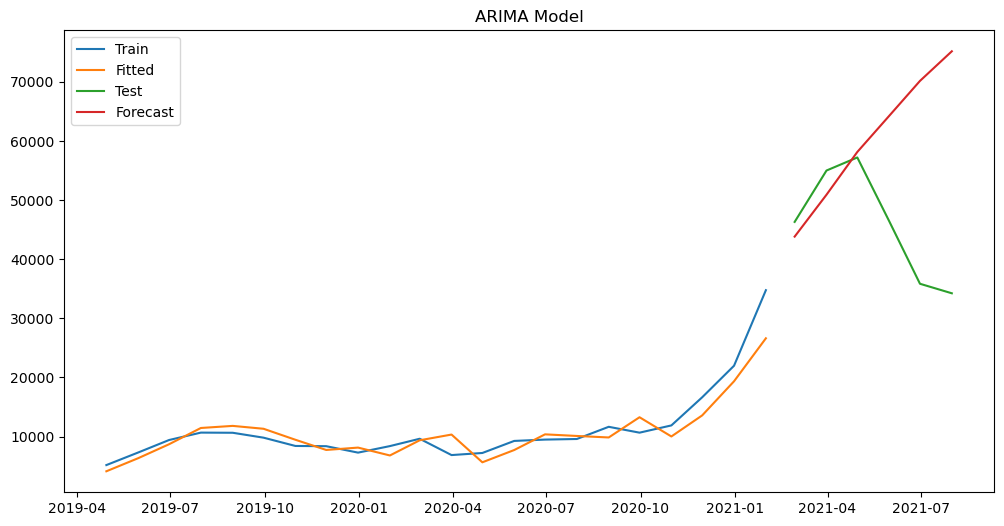

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('ARIMA Model')
plt.plot(train_arima.index[72:], train_arima[72:], label='Train')
plt.plot(train_arima.index[72:], fitted_values[72:], label='Fitted')
plt.plot(test_arima.index, test_arima, label='Test')
plt.plot(test_arima.index, forecast, label='Forecast')
plt.legend()
plt.show()

The forecast is poor, the predictions completely contradict the actual values once the trend reverses.

Let's try some daily forecasting with machine learing regressors. 

In [109]:
lag_count = 30
bitcoin_lagged = bitcoin[['Close']].copy()
for i in range(lag_count,0,-1):
    bitcoin_lagged['t='+str(i)] = bitcoin_lagged['Close'].shift(i)
bitcoin_lagged.dropna(inplace=True)
bitcoin_lagged['weekday'] = bitcoin_lagged.index.weekday
bitcoin_lagged['day_of_month'] = bitcoin_lagged.index.day
bitcoin_lagged['day_of_year'] = bitcoin_lagged.index.dayofyear
bitcoin_lagged.head()

,Close,t=30,t=29,t=28,t=27,t=26,t=25,t=24,t=23,t=22,...,t=7,t=6,t=5,t=4,t=3,t=2,t=1,weekday,day_of_month,day_of_year
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-29 23:59:59,132.300003,144.539993,139.000000,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,...,123.889000,126.699997,133.199997,131.979996,133.479996,129.744995,129.000000,2,29,149
2013-05-30 23:59:59,128.798996,139.000000,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,...,126.699997,133.199997,131.979996,133.479996,129.744995,129.000000,132.300003,3,30,150
2013-05-31 23:59:59,129.000000,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,...,133.199997,131.979996,133.479996,129.744995,129.000000,132.300003,128.798996,4,31,151
2013-06-01 23:59:59,129.300003,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,...,131.979996,133.479996,129.744995,129.000000,132.300003,128.798996,129.000000,5,1,152
2013-06-02 23:59:59,122.292000,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,115.242996,...,133.479996,129.744995,129.000000,132.300003,128.798996,129.000000,129.300003,6,2,153


In [110]:
forecast_length = 30
train = bitcoin_lagged.iloc[:-forecast_length]
test = bitcoin_lagged.iloc[-forecast_length:]

In [111]:
from sklearn.model_selection import train_test_split

X = train.drop('Close', axis=1)
y = train['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [112]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [113]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=300, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=300, random_state=42)

In [114]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = rf_model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)*100

3.0083211809625627

In [115]:

y_pred = gb_model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)*100

3.6885648046326303

In [142]:
import numpy as np


def get_first_eval_batch(data, n):
    return data[-n:].reshape(-1, n)

def make_dynamic_predictions(train_data, test_data, model, lag_count):
    test_prediction_rfr = []
    current_batch = get_first_eval_batch(train_data, lag_count)

    for i in range(len(test_data)):
        current_batch_df = pd.DataFrame(current_batch, columns=X_train.columns)
        current_pred = model.predict(current_batch_df)[0]
        test_prediction_rfr.append(current_pred)
        current_batch = np.append(current_batch[:,1:], current_pred).reshape(-1, lag_count)
    return test_prediction_rfr

In [116]:
def make_predictions(model):
    X_test = test.drop('Close', axis=1)
    y_pred = model.predict(X_test)
    
    return y_pred

In [49]:
def get_naive_forecast():
    return bitcoin['Close'].shift(1).iloc[-forecast_length:]

In [117]:
test_prediction_rfr = make_predictions(rf_model)
test_prediction_gb = make_predictions(gb_model)

In [118]:
print(f'Rfr MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_rfr)*100}')
print(f'GB MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_gb)*100}')

Rfr MAPE: 4.2147679831476985
GB MAPE: 4.816807518895295


In [119]:
from sklearn.metrics import mean_absolute_percentage_error

naive_forecast = get_naive_forecast()
print(f'Naive MAPE: {mean_absolute_percentage_error(test["Close"], naive_forecast)*100}')

Naive MAPE: 3.789446641682695


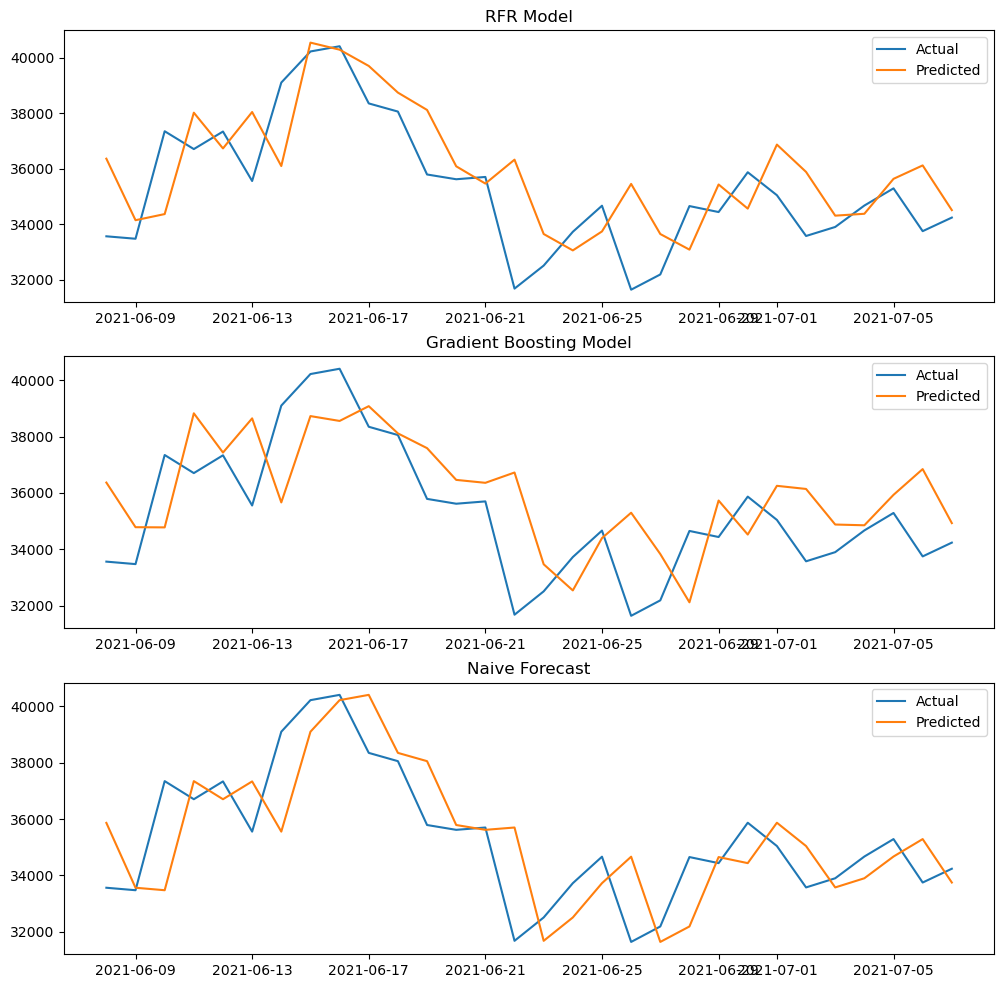

In [120]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(12, 12))

axs[0].plot(test.index, test['Close'], label='Actual')
axs[0].plot(test.index, test_prediction_rfr, label='Predicted')
axs[0].set_title('RFR Model')
axs[0].legend()


axs[1].plot(test.index, test['Close'], label='Actual')
axs[1].plot(test.index, test_prediction_gb, label='Predicted')
axs[1].set_title('Gradient Boosting Model')
axs[1].legend()

axs[2].plot(test.index, test['Close'], label='Actual')
axs[2].plot(test.index, naive_forecast, label='Predicted')
axs[2].set_title('Naive Forecast')
axs[2].legend()

plt.show()

Naive forecast is better than the non-dynamic predictions made by the models.

In [121]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = X.values
X = scaler.fit_transform(X)

X_test = test.drop('Close', axis=1)
X_test = X_test.values
X_test = scaler.transform(X_test)

Y = y.values
Y = scaler.fit_transform(Y.reshape(-1, 1))

Y_test = test['Close']

In [122]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(X, Y, epochs=50, verbose=1, batch_size=32)

c:\Users\mwdzi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0095
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0015
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.3514e-04
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.2096e-04
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.7939e-04
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.2797e-04
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.8798e-04
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.4820e-04
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.5008e-04
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.0238e-04
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.7775e-04
Epoch 12/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.5117e-04
Epoch 13/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.7663e-04
Epoch 14/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.9133e-04
Epoch 15/50
92/92 ━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


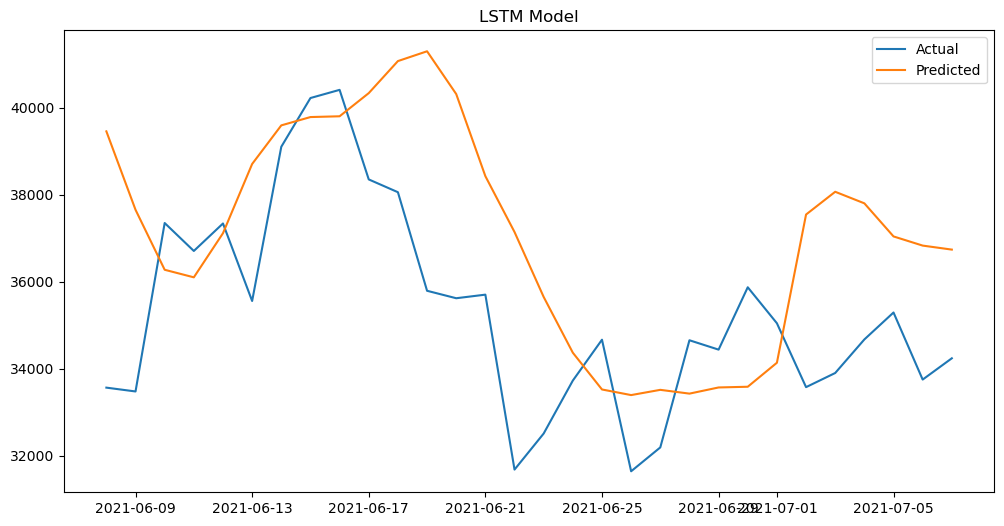

In [123]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(12, 6))
plt.plot(Y_test.index, Y_test, label='Actual')
plt.plot(Y_test.index, predictions, label='Predicted')
plt.title('LSTM Model')
plt.legend()
plt.show()

In [124]:
mean_absolute_percentage_error(Y_test, predictions)*100

6.9486366767512395